Import libraries

In [1]:
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from scipy import signal
from matplotlib import cm

Find detections

In [2]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

FileNotFoundError: [Errno 2] No such file or directory: './data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'

Select detection

In [5]:
row = cat.iloc[6]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time

datetime.datetime(1970, 6, 26, 20, 1)

In [6]:
arrival_time_rel = row['time_rel(sec)']
arrival_time_rel

np.float64(72060.0)

In [7]:
test_filename = row.filename
test_filename

'xa.s12.00.mhz.1970-06-26HR00_evid00009'

Read CSV

In [8]:
data_directory = './data/lunar/training/data/S12_GradeA/'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)
data_cat

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1970-06-26T00:00:00.116000,0.000000,-6.727977e-16
1,1970-06-26T00:00:00.266943,0.150943,-8.646711e-16
2,1970-06-26T00:00:00.417887,0.301887,-9.298738e-16
3,1970-06-26T00:00:00.568830,0.452830,-8.589095e-16
4,1970-06-26T00:00:00.719774,0.603774,-7.139047e-16
...,...,...,...
572418,1970-06-27T00:00:02.832981,86402.716981,5.039820e-17
572419,1970-06-27T00:00:02.983925,86402.867925,-9.191068e-18
572420,1970-06-27T00:00:03.134868,86403.018868,-2.796955e-17
572421,1970-06-27T00:00:03.285811,86403.169811,-9.037156e-17


Plot graph

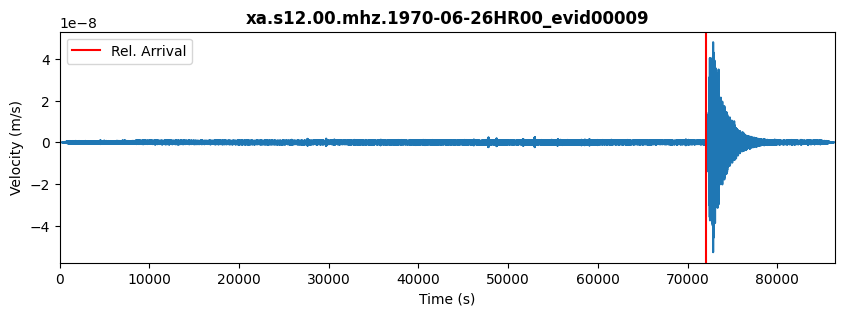

In [9]:
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

Read miniseed file correspoding to the reading

In [12]:
data_directory = './data/lunar/training/data/S12_GradeA/'
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(mseed_file)
st

1 Trace(s) in Stream:
XA.S12.00.MHZ | 1970-06-26T00:00:00.116000Z - 1970-06-27T00:00:03.436755Z | 6.6 Hz, 572423 samples

In [13]:
# The stream file also contains some useful header information
st[0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1970-06-26T00:00:00.116000Z
         endtime: 1970-06-27T00:00:03.436755Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572423
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

In [14]:
# This is how you get the data and the time, which is in seconds
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

# Start time of trace (another way to get the relative arrival time using datetime)
starttime = tr.stats.starttime.datetime
arrival = (arrival_time - starttime).total_seconds()
arrival

72059.884

Filter the data

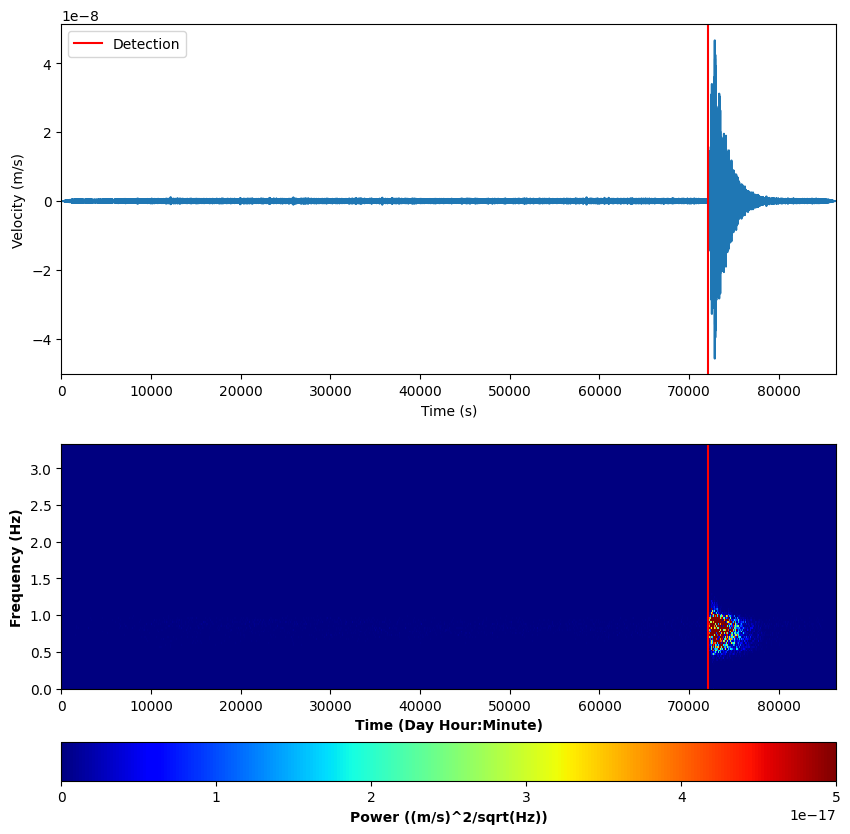

In [15]:
# Set the minimum frequency
minfreq = 0.5
maxfreq = 1.0

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

# Mark detection
ax.axvline(x = arrival, color='red',label='Detection')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')